<a href="https://colab.research.google.com/github/Kentea-Watanabe/color_kmeans/blob/main/color_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import collections
import glob
import os
import random

import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt

from PIL import Image

def imshow(img):
    """ndarray 配列をインラインで Notebook 上に表示する。
    """
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [ ]:
# upload images (PNG or JPG)
image_name = list(files.upload().keys())
input_image = cv2.imread(image_name[0])

Saving handsam01.jpg to handsam01.jpg


In [ ]:
!git clone https://github.com/Kentea-Watanabe/yolov5_face_detection.git
%cd yolov5_face_detection

!git clone https://github.com/ultralytics/yolov5 # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

Cloning into 'yolov5_face_detection'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 89 (delta 25), reused 82 (delta 24), pack-reused 5
Unpacking objects: 100% (89/89), done.
/content/yolov5_face_detection
Cloning into 'yolov5'...
remote: Enumerating objects: 14302, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 14302 (delta 26), reused 25 (delta 8), pack-reused 14242
Receiving objects: 100% (14302/14302), 13.59 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (9833/9833), done.
     |████████████████████████████████| 182 kB 4.8 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 1.6 MB 65.0 MB/s 
/content/yolov5_face_detection/yolov5


In [ ]:
import torch
from IPython.display import Image, clear_output

yolo_weight = "/content/yolov5_face_detection/weights/best.pt"
yolo_dir = "/content/yolov5_face_detection/yolov5"

d_model = torch.hub.load(yolo_dir, 'custom', path=yolo_weight, source='local')

YOLOv5 🚀 v7.0-23-g5dc1ce4 Python-3.8.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s-mask summary: 232 layers, 7249215 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# クラスター数
num_cluster = 7

# 画像表示のリサイズに使用
w = 200
h = 200

input_im_path = "/content/handsam01.jpg"

元画像


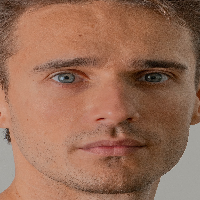

ret: 595354272.23, label: (2769200, 1), center: (7, 3)


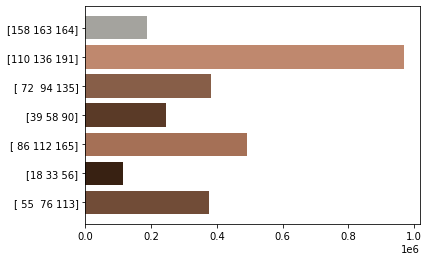

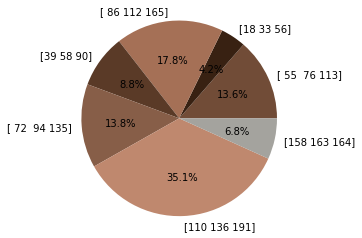

In [ ]:
%matplotlib inline

input_img = cv2.imread(input_im_path)
input_pred_im = d_model(input_img) 
input_det_im = input_pred_im.crop(save=False)
img = input_det_im[0]["im"]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 表示のためにリサイズ
im_ = cv2.resize(img, dsize=(w, h))
print('元画像')
cv2_imshow(im_)

# 画像で使用されている色一覧。(W * H, 3) の numpy 配列。
colors = img.reshape(-1, 3).astype(np.float32)

# クラスタ数
K = num_cluster

# 最大反復回数: 10、移動量の閾値: 1.0
criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0

ret, labels, centers = cv2.kmeans(
    colors, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS
)

print(f"ret: {ret:.2f}, label: {labels.shape}, center: {centers.shape}")

labels = labels.squeeze(axis=1)  # (N, 1) -> (N,)
centers = centers.astype(np.uint8)  # float32 -> uint8
# 各クラスタに属するサンプル数を計算する。
_, counts = np.unique(labels, axis=0, return_counts=True)

# matplotlib の引数の仕様上、[0, 1] にして、(R, G, B) の順番にする。
bar_color = centers[:, ::-1] / 255
bar_text = list(map(str, centers))

# ヒストグラムを表示する。
plt.barh(np.arange(K), counts, color=bar_color, tick_label=bar_text)
plt.show()

# ヒストグラムから円グラフを作成する
plt.pie(counts, labels=bar_text, colors=bar_color,autopct='%1.1f%%')
plt.axis('equal')
plt.show()